<a href="https://colab.research.google.com/github/dorigonato/Face_Detection/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as bibliotecas
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
# Funções auxiliares para converter entre formatos de imagem
def js_to_image(js_reply):
    """Converte um objeto JavaScript em uma imagem OpenCV."""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    """Converte uma caixa delimitadora em bytes para sobrepor na imagem."""
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes


In [4]:
# Inicializa o modelo Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


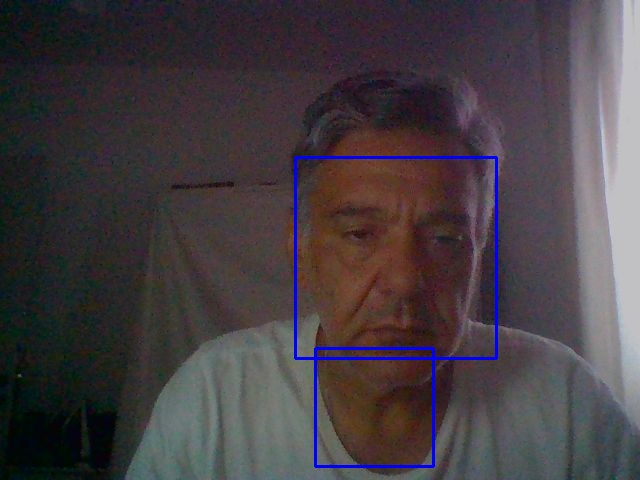

In [6]:
# Função para capturar uma foto da webcam usando JavaScript e detecção de faces com Haar Cascade
def take_photo(filename='/content/photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    faces = face_cascade.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.imwrite(filename, img)
    return filename

try:
    filename = take_photo('photo.jpg')
    print('Saved to {}'.format(filename))
    display(Image(filename))
except Exception as err:
    print(str(err))

In [11]:
# Funções para criar o fluxo de vídeo da webcam e detectar faces com Haar Cascade
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


video_stream()

label_html = 'Capturing...'

bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convertendo resposta JS para OpenCV Image
    img = js_to_image(js_reply["img"])

    # Correct indentation for the following line:
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # imagem em escala de cinza para detecção de face
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # pegando as coordenadas da região da face
    faces = face_cascade.detectMultiScale(gray)

    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    bbox_bytes = bbox_to_bytes(bbox_array)

    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [12]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Clona o repositório darknet
!git clone https://github.com/AlexeyAB/darknet


%cd darknet

# Edita o arquivo Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

# Compila o Darknet
!make

# Baixar os pesos pré-treinados do YOLOv4 (scaled-YOLOv4)
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

Cloning into 'darknet'...
remote: Enumerating objects: 15873, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15873 (delta 12), reused 7 (delta 7), pack-reused 15850 (from 3)
Receiving objects: 100% (15873/15873), 14.50 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (10679/10679), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: va

In [13]:
# Importa as funções do darknet.py para usar o YOLOv4
from darknet import *

# Carrega a rede YOLOv4 e os nomes das classes
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# Função auxiliar para executar a detecção do YOLOv4 em uma imagem
def darknet_helper(img, width, height):
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                                interpolation=cv2.INTER_LINEAR)

    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image)
    free_image(darknet_image)
    return detections, width_ratio, height_ratio

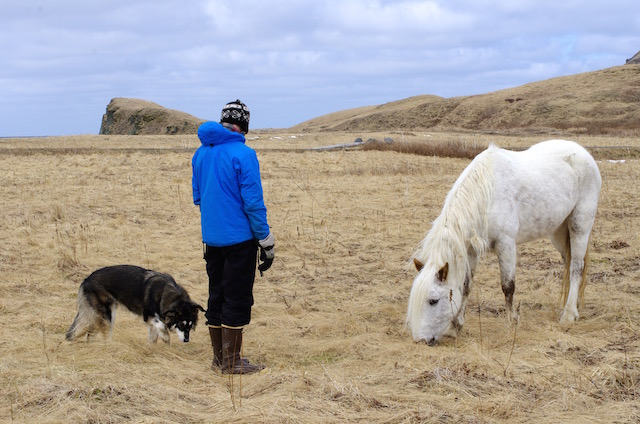

In [14]:
# Roda o teste em uma imagem
image = cv2.imread("data/person.jpg") # usa uma imagem de exemplo do darknet
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

<IPython.core.display.Javascript object>

Saved to photo.jpg


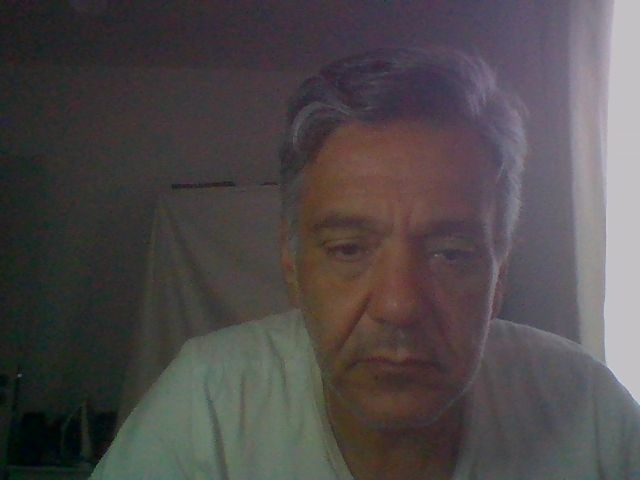

In [15]:
# Usa a função take_photo com o YOLOv4
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    detections, width_ratio, height_ratio = darknet_helper(img, width, height)

    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
      cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
    cv2.imwrite(filename, img)
    return filename

try:
    filename = take_photo('photo.jpg')
    print('Saved to {}'.format(filename))
    display(Image(filename))
except Exception as err:
    print(str(err))

In [16]:
# Adapta o código do vídeo da webcam para usar o YOLOv4
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                { video: { facingMode: "environment" } });
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                '<span style="color: red; font-weight: bold;">' +
                'When finished, click here or on the video to stop this demo</span>';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640; //video.videoWidth;
            captureCanvas.height = 480; //video.videoHeight;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }
        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label != "") {
                labelElement.innerHTML = label;
            }

            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function (resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {
                'create': preShow - preCreate,
                'show': preCapture - preShow,
                'capture': Date.now() - preCapture,
                'img': result
            };
        }
    ''')
    display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>